In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from math import sqrt


import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from statsmodels.tsa.stattools import acf, pacf

from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import AdaBoostRegressor
import cudf 
from cuml.linear_model import LinearRegression , Lasso  

from sklearn.preprocessing import StandardScaler 
from cuml.svm import SVR

pd.options.display.max_columns = 500


In [3]:
# Read csv file
datac = pd.read_csv('../input/beijing-air-quality-preprocessed/airquality_data.csv')

In [4]:
# Split data into train and test
train_data, test = train_test_split(datac,
                               test_size=0.1,
                               shuffle=False)

In [5]:
# Split data into train and valid
train, valid = train_test_split(train_data,
                               test_size=0.1,
                               shuffle=False)

In [7]:
sc = StandardScaler()

# Feature Engineering

## PACF
This function was introduced as part of the Box–Jenkins approach to time series modelling, whereby plotting the partial autocorrelative functions one could determine the appropriate lags **p** in an AR **(p)** model or in an extended ARIMA **(p,d,q)** model.

We choose for example the explanatory variable `PM10` and how it is correlated in time.

We noticed that all variable verify the same plot meaning the best lag is two.

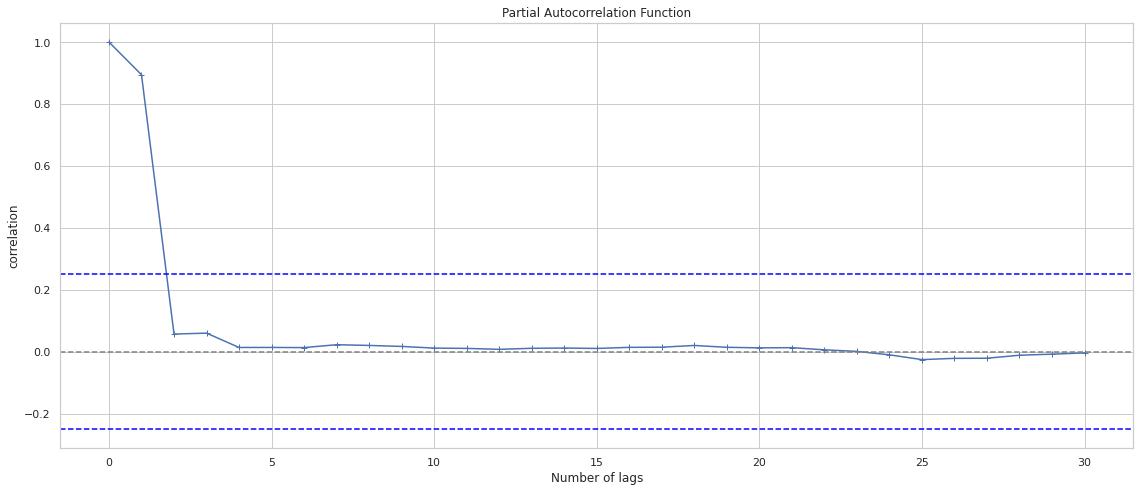

In [8]:
# The variable we choose to apply pacf
y = train['PM10']

#calling partial correlation function
lag_pacf = pacf(y, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y= -((np.std(y) * 1.96)) / np.sqrt(len(y)), linestyle='--',color='blue') # lower bound
plt.axhline(y= ((np.std(y) * 1.96)) / np.sqrt(len(y)),linestyle='--',color='blue') # Upper bound
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In [9]:
def series_to_supervised(data_df, lag=2):
    
    '''Create lagged features'''
    
    # We create the lag features with the pandas function shift
    lag_df = data_df[[col for col in data_df.columns if col not in ['No', 'year', 'month', 'day', 'hour']]].shift(lag)
    
    # We rename the columùns by adding lag_{lag_value} at the end
    lag_df.columns = [col+"_"+f"lag_{lag}" for col in lag_df.columns]
    
    return lag_df

def rolling_window(data_df, window=1):
    
    # We create the rolling mean features (MA) with the pandas function shift
    rolling_df = data_df[[col for col in data_df.columns if col not in ['No','station', 'wd', 'year', 'month', 'day', 'hour', 'PM2.5']]].rolling(window).mean()
    
    # We rename the columùns by adding rolling_{window} at the end
    rolling_df.columns = [col+"_"+f"rolling_{window}" for col in rolling_df.columns]
    
    return rolling_df

In [10]:
# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train, lag=1)
train_lag2 = series_to_supervised(train, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train, window=2)

# Concat everything together
train = pd.concat([train, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train['cum_wspm'] = train['WSPM'].cumsum()

# Saturated vapor pressure
train['saturated_vapor_pressure'] = 6.11*10*((7.5*train['TEMP'])/(237.3+train['TEMP']))
# Actual vapor pressure
train['actual_vapor_pressure'] = 6.11*10*((7.5*train['DEWP'])/(237.3+train['DEWP']))

# Lag features by shift(1) and shift(2)
valid_lag1 = series_to_supervised(valid, lag=1)
valid_lag2 = series_to_supervised(valid, lag=2)

# Rolling window by 2
valid_rolling2 = rolling_window(valid, window=2)

# Concat everything together
valid = pd.concat([valid, valid_lag1, valid_lag2, valid_rolling2], axis=1).dropna()

# Cumulative wind speed
valid['cum_wspm'] = valid['WSPM'].cumsum()

# Saturated vapor pressure
valid['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['TEMP']) / (237.3 + valid['TEMP']))
# Actual vapor pressure
valid['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['DEWP']) / (237.3 + valid['DEWP']))


# Lag features by shift(1) and shift(2)
test_lag1 = series_to_supervised(test, lag=1)
test_lag2 = series_to_supervised(test, lag=2)

# Rolling window by 2
test_rolling2 = rolling_window(test, window=2)

# Concat everything together
test = pd.concat([test, test_lag1, test_lag2, test_rolling2], axis=1).dropna()

# Cumulative wind speed
test['cum_wspm'] = test['WSPM'].cumsum()

# Saturated vapor pressure
test['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['TEMP']) / (237.3 + test['TEMP']))
# Actual vapor pressure
test['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['DEWP']) / (237.3 + test['DEWP']))

# endogenous variables
features_columns = [col for col in train.columns if col not in ['No', 'PM2.5']]

del train_lag1, train_lag2, train_rolling2
del valid_lag1, valid_lag2, valid_rolling2
del test_lag1, test_lag2, test_rolling2

_ = gc.collect()

In [ ]:
       
sc.fit(train[features_columns])
train[features_columns] = sc.transform(train[features_columns])
valid[features_columns] = sc.transform(valid[features_columns])
test[features_columns] = sc.transform(test[features_columns])

#clf = SVR()
#clf.fit(train[features_columns], train["PM2.5"])

adab_params = AdaBoostRegressor(
    SVR(),
    n_estimators=10,
    random_state=42,
)
model = adab_params.fit(train[features_columns],np.log(train["PM2.5"]))

# Predictions and score on validation data
pred_val = model.predict(valid[features_columns])
pred_test = model.predict(test[features_columns])

rmse_score_valid = mse(y_true=valid["PM2.5"], y_pred=np.exp(pred_val))
mae_score_valid = mae(y_true=valid["PM2.5"], y_pred=np.exp(pred_val))
msle_score_valid = msle(y_true=valid["PM2.5"], y_pred=np.exp(pred_val))
r2_score_valid = r2(y_true=valid["PM2.5"], y_pred=np.exp(pred_val))

rmse_score_test = mse(y_true=test["PM2.5"], y_pred=np.exp(pred_test))
mae_score_test = mae(y_true=test["PM2.5"], y_pred=np.exp(pred_test))
msle_score_test = msle(y_true=test["PM2.5"], y_pred=np.exp(pred_test))
r2_score_test = r2(y_true=test["PM2.5"], y_pred=np.exp(pred_test))
print("\n")

print(f"Adaboost rmse valid: {sqrt(rmse_score_valid)}")
print(f"Adaboost mae valid: {mae_score_valid}")
print(f"Adaboost rmsle valid: {sqrt(msle_score_valid)}")
print(f"Adaboost r2 valid{r2_score_valid}")
print('\n')
print(f"Adaboost rmse test: {sqrt(rmse_score_test)}")
print(f"Adaboost mae valid: {mae_score_test}")
print(f"Adaboost rmsle valid: {sqrt(msle_score_test)}")
print(f"Adaboost r2 test: {r2_score_test}")

# Configuration

In [ ]:
N_SPLITS = 5
SEED = 42

In [ ]:
train_data.shape[0] // (N_SPLITS + 1)

In [ ]:
np.ceil(train_data.shape[0]*0.1).astype(int)

In [ ]:
oof_adab = np.zeros((train_data.shape[0]))
oof_target = np.zeros((train_data.shape[0]))

predictions_adab = np.zeros((test.shape[0]))
counter = 1


rmse_scores_adab = []
r2_scores_adab = []
adab_params = AdaBoostRegressor(
    SVR(),
    n_estimators=10,
    random_state=42,
)
# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train_data, lag=1)
train_lag2 = series_to_supervised(train_data, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train_data, window=2)

# Concat everything together
train_data = pd.concat([train_data, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train_data['cum_wspm'] = train_data['WSPM'].cumsum()

# Saturated vapor pressure
train_data['saturated_vapor_pressure'] = 6.11*10*((7.5*train_data['TEMP'])/(237.3+train_data['TEMP']))
# Actual vapor pressure
train_data['actual_vapor_pressure'] = 6.11*10*((7.5*train_data['DEWP'])/(237.3+train_data['DEWP']))

# Features to use for training and prediction
features_columns = [col for col in train_data.columns if col not in ['No', 'PM2.5']]

# TimeSeriesSplit validation 
tsp = TimeSeriesSplit(n_splits=5, test_size=np.ceil(train_data.shape[0]*0.1).astype(int))


for trn_idx, vld_idx in tsp.split(train_data):
    
    
    # train valid separation
    print(f"CV {counter}/{N_SPLITS}")
    print('\n')
    x_train, y_train = train_data.iloc[trn_idx][features_columns], train_data.iloc[trn_idx]["PM2.5"]
    x_val, y_val = train_data.iloc[vld_idx][features_columns], train_data.iloc[vld_idx]["PM2.5"]
    d_test = test[features_columns].astype("float")
    
    # Fit and train Adaboost
    model = AdaBoostRegressor(adab_params)
    model.fit(x_train, y_train) 

    # Predictions and score on validation data
    pred_val = model.predict(x_val)
    pred_test = model.predict(d_test)
    
    rmse_score_valid = mse(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    r2_score_valid = r2(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    print('\n')
    print(f"Fold {counter} Adaboost rmse: {sqrt(rmse_score_valid)}")
    print(f"Fold {counter} Adaboost r2: {r2_score_valid}")
    print('\n')
    rmse_scores_adab.append(sqrt(rmse_score_valid))
    r2_scores_adab.append(r2_score_valid)
    oof_adab[vld_idx] = pred_val
    oof_target[vld_idx] = train_data.iloc[vld_idx]["PM2.5"]
    predictions_adab += pred_test / N_SPLITS
    counter += 1

# CV score
rmse_score_cv = mse(y_true=oof_target, y_pred=oof_adab)
r2_score_cv = r2(y_true=oof_target, y_pred=oof_adab)

    
# Inference score
rmse_score_test = mse(y_true=test["PM2.5"], y_pred=predictions_adab)
r2_score_test = r2(y_true=test["PM2.5"], y_pred=predictions_adab)

print(f"Adaboost rmse cv: {sqrt(rmse_score_cv)}")
print(f"Adaboost r2 cv{r2_score_cv}")
print('\n')
print(f"Adaboost rmse test: {sqrt(rmse_score_test)}")
print(f"Adaboost r2 test: {r2_score_test}")